# **Stock Price Prediction Using Historical Data and Recurrent Neural Networks (RNNs)** 

### **Author:** Reece Iriye
### **Course:** MATH 4377 (Math of Machine Learning)
### **Section:** Fall 2022, TTh 12:30-1:50PM, 001-LEC
### **Department:** Mathematics

## **Project Description**

This project studies the usage of historical data and recurrent neural network to predict a stock price or an index. I will choose to use regression to predict a stock price or an index, instead of classification to predict whether or not there exists an overall upward or downward trend.

### **Data Generation**

1. Go to http://finance.yahoo.com
2. Search one (or several, depending on the need for your model) of the stocks from a company (apple, amazon, microsoft, etc.) or one or several stock indices (S&P 500, Dow 30, Nasdaq, Russell 2000, Crude Oil, etc.)
3. Once the stock or index’s quote page is shown, click the “Historic Data” tab and change “the time period” as needed. Note normally we prefer more data for a neural network.
4. Click “Apply” and then click “download” below the “Apply” button and a CSV data will be generated and downloaded to your computer.


*Note*: I will need to pick a time period and decide how many data points to produce. I will need to rearrange the data into time series by lagging the data to obtain percentage returns instead of raw closing price data. I will also need to split my data into a training set and a testing set thus the validation can be performed. 

### **Recurrent Neural Network (RNN)**

I need to setup a RNN model and use the obtained data to predict stock prices. I will consider the following questions when you setup the RNN:


1. What's the overall dimension of the RNN?
2. What is the number of time steps for returns? In predicting n-day returns, what am I specifying as n?
3. How many neurons are in the hidden layer?
4. Did I use the LSTM, if so what are the related parameters?
5. What is my choice of activation function? Why?

### **Research Objective**

Through this project, I will demonstrate:
1. Cleaning and rearranging data in the form that a neural network can be applied on.
2. Setting up a RNN model that is working.
3. Further tuning the model by modifying model parameters to finalize an optimized model.
4. Getting *creative* based on accumulated knowledge and skills.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  # for splitting dataset
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential   # the RNN model
from tensorflow.keras.layers import Embedding, LSTM, Dense  # layers of the architecture

## **Project Implementation**

### **Generate Necessary Data**

I will predict Target Corporation's (NYSE: TGT) returns in 2019 using historical data from 01/02/2000 - 12/31/2018. Using Bloomberg Terminal which is downloaded on the computers in SMU's business library, I will scrape data using the `BDH` Excel function connected with Bloomberg and download the data to a CSV file, so I can store closing price data into a DataFrame using Pandas. I used Bloomberg Terminal instead of Yahoo Finance, because Yahoo did not allow me to download the closing price data from every single one of my indices and equities that I wanted to use for the project.



Additionally, I'm using the training time period from 2000-2018, because that time period captures a wide array of market phases that the United States has gone through, with some periods of growth but also with the Stock Market Crash of 2008. I'm using 2019 as a testing year, because it may be somewhat predictable especially with the market trends happening a couple years before it that I will train the RNN on. I did not want to test it on 2020, because my model likely would not have factored in the COVID crash that occurred based solely on historical data of various indices and equities.



Predictors for TGT that I'll include:
- Benchmark Indices:
    - SPX Index
        - The SPX Index, also known as the S&P 500, is the basic index that generally describes the overall state of the market based on the top 500 performing companies.
    - RUI Index (Russell 1000)
        - The Russell 1000 represents the top 1000 companies by market capitalization in the United States.
    - FED5YEAR Index
        - The FED5Year is the yield of a US Treasury note that pays out in 5 years. 
    - VIX Index
        - VIX is the volatility index that measures the volatility of the S&P 500 options and shows how volatile the stock market can be at certain times.
    - DXY Curncy
        - DXY measures the price of the US Dollar in comparison to other currencies.
- Competitor Indices:
    - Costco Wholesale Corporation (NASDAQ: COST)
    - Walmart Inc (NYSE: WMT)
    - Macy's Inc (NYSE: M)
- Industry-Specific Metric:
    - SPSIRE (S&P Retail Select Industry Index)
        - SPSIRE measures the performance of the retail sector in the stock market. 


I am using all these factors, because I wanted to use a variety of predictors that represent the overall state of the market, the performance of the US dollar, the performance of competitors who are similar in nature, the retail sector's performance, and the TGT historical data itself. Using only a couple of these factors I believe would have limited myself, and I wanted to branch out using multiple predictors to hopefully build an accurate model.

In [2]:
df_pxlast = pd.read_csv("data/full_data.csv")
df_pxlast.head(10)

,Date,SPX,RUI,FED5YEAR,VIX,DXY,COST,WMT,M,SPSIRE,TGT
0,1/2/00,1469.25,3055.86,2.7701,24.64,101.87,45.625,69.1250,25.2813,1041.97,36.7188
1,1/3/00,1455.22,3029.45,2.7473,24.21,100.22,44.500,66.8125,25.1875,1016.40,36.0313
2,1/4/00,1399.42,2909.98,2.8377,27.01,100.41,42.063,64.3125,24.4688,989.24,34.4688
3,1/5/00,1402.11,2917.77,2.8245,26.41,100.38,42.781,63.0000,24.9375,989.65,33.6875
4,1/6/00,1403.45,2898.75,2.7696,25.73,100.48,43.641,63.6875,24.7188,990.10,32.0938
5,1/9/00,1441.47,2998.01,2.6760,21.72,100.72,46.531,68.5000,25.4063,1010.94,33.7500
6,1/10/00,1457.60,3041.51,2.5936,21.71,100.99,47.500,67.2500,26.1875,1019.65,33.0938
7,1/11/00,1438.56,2996.16,2.7436,22.50,100.56,45.813,66.2500,25.3438,1005.29,34.0938
8,1/12/00,1432.25,2985.80,2.8011,22.84,100.62,45.750,65.0625,25.2813,992.22,33.7188
9,1/13/00,1449.68,3031.35,2.7769,21.71,101.00,47.469,65.1250,25.6250,996.90,34.5000


All of the closing price data for my predictors has been imported successfully. Now let's do the same for my testing data solutions of TGT closing prices to check whether or not that has been imported successfully as well

### **Generate Returns Data Using Lags of Closing Price Data**

All data has been imported successfully into Pandas Dataframes. Now,  transform all the data into percentage returns data, because percentage returns have a mean-reverting characteristic that represents the normal distribution. We want a distribution like this, because it makes predictions more accurately in relation to its actual shape, instead of general closing price data which has a more $\chi^2$ shape associated with it. 



Also, change the dates to datetime types in the Pandas DataFrame while we're already observing other values.

In [3]:
df_returns = pd.DataFrame()
for index, colname in enumerate(df_pxlast):
    if colname == "Date":
        df_returns[colname] = pd.to_datetime(df_pxlast[colname][1:])
    else:
        df_returns[colname + " Returns"] = df_pxlast[colname].pct_change(1)
df_returns.set_index(df_returns["Date"], inplace=True)
df_returns.drop("Date", axis=1, inplace=True)

In [4]:
df_returns.head()

,SPX Returns,RUI Returns,FED5YEAR Returns,VIX Returns,DXY Returns,COST Returns,WMT Returns,M Returns,SPSIRE Returns,TGT Returns
Date,,,,,,,,,,
2000-01-03,-0.009549,-0.008642,-0.008231,-0.017451,-0.016197,-0.024658,-0.033454,-0.003710,-0.024540,-0.018723
2000-01-04,-0.038345,-0.039436,0.032905,0.115655,0.001896,-0.054764,-0.037418,-0.028534,-0.026722,-0.043365
2000-01-05,0.001922,0.002677,-0.004652,-0.022214,-0.000299,0.017070,-0.020408,0.019155,0.000414,-0.022667
2000-01-06,0.000956,-0.006519,-0.019437,-0.025748,0.000996,0.020102,0.010913,-0.008770,0.000455,-0.047308
2000-01-09,0.027090,0.034242,-0.033795,-0.155849,0.002389,0.066222,0.075564,0.027813,0.021048,0.051605


I specifically chose to use 1-day returns, because it's a decent gage on daily market activity and may work well when testing the model.

## **Split the Data into a Training Set and a Testing Set**

Now that I have the data that I need categorized correctly, I will split the data into training and testing sets to ensure that we can apply the Recurrent Neural Network correctly. Based on the Time Series nature of the RNN, and based on my data and the custom dates that I want to use, I will *not* need to invoke the `train_test_split()` module from `scikit-learn`. Instead, I will create a new column in df_returns to indicate whether or not I will train the data on its content.

In [5]:
X_train = df_returns.loc["2000-01-03":"2018-12-31", "SPX Returns":"SPSIRE Returns"]
X_train.tail()

,SPX Returns,RUI Returns,FED5YEAR Returns,VIX Returns,DXY Returns,COST Returns,WMT Returns,M Returns,SPSIRE Returns
Date,,,,,,,,,
2018-12-25,0.000000,0.000000,0.000000,0.000000,0.000290,0.000000,0.000000,0.000000,0.000000
2018-12-26,0.049594,0.049689,0.002082,-0.156917,0.004856,0.045476,0.053484,0.070337,0.058489
2018-12-27,0.008563,0.008387,-0.015526,-0.014798,-0.005863,0.012334,0.013052,-0.002987,-0.002474
2018-12-30,-0.001242,-0.000809,0.000444,-0.054072,-0.000819,0.004774,0.005896,-0.000666,0.004232
2018-12-31,0.008492,0.008830,-0.017540,-0.103035,-0.002375,0.008266,0.011071,-0.007995,0.006084


In [6]:
X_test = df_returns.loc["2019-01-01":"2019-12-31", "SPX Returns":"SPSIRE Returns"]
print(f"Shape of X_test is {X_test.shape}")

Shape of X_test is (261, 9)


In [7]:
y_train = df_returns.loc["2000-01-03":"2018-12-31", ["TGT Returns"]]
y_train.tail()

,TGT Returns
Date,
2018-12-25,0.000000
2018-12-26,0.057839
2018-12-27,-0.006143
2018-12-30,0.003863
2018-12-31,0.017395


In [8]:
y_test = df_returns.loc["2019-01-01":"2019-12-31", ["TGT Returns"]]
print(f"Shape of y_test is {y_test.shape}")

Shape of y_test is (261, 1)


One limitation to my data is that when scraping the closing price data using Bloomberg Excel functions, I didn't account for holiday closing prices to be omitted from the dataset. For indices and equities that close when the U.S. market closes during these days, the returns will be listed as 0, because the closing prices in the dataset for these points of data are equivalent to the day before, thus invoking a 0% change.

### **Convert Training Data to LSTM Format**

I will now be transforming our `X_train` and `X_test` variables into numpy arrays so I can put them into Long Short-Term Memory (LSTM) format. The reason I need to make this change is because the model will only take in my data if it is in that specific format. My training and testing set for X will need to be reshaped using the `.reshape()` function from numpy, which will need to indicate batch size, time steps, and the number of features in our entire model.



To further describe LSTM format, it essentially is an architecture employed in various RNNs because it is able to capture long-term dependencies in the data. This allows for the model to retain important information for longer periods of time, which I believe is crucial in a task like predicting stocks, because it requires remembering previous events to predict future events.

In [9]:
# Convert DataFrames to numpy arrays
X_train_2D = X_train.values
X_test_2D  = X_test.values

# Obtain number of timesteps and feature count based on shape of DataFrame
num_features_train = X_train.shape[1]
num_features_test  = X_test.shape[1]

print(f"The shape of X_train is {X_train.shape}\nThe shape of X_test is {X_test.shape}")

# Reshape the 2D array into a 3D array
X_train_3D = np.reshape(X_train_2D, (1652, 3, num_features_train))
X_test_3D  = np.reshape(X_test_2D, (87, 3, num_features_test))

The shape of X_train is (4956, 9)
The shape of X_test is (261, 9)


In [10]:
# Perform similar actions on y_train and y_test
y_train_new = y_train.values
y_test_new = y_test.values

# Reshape into 2D array
y_train_2D = np.reshape(y_train_new, (1652, 3))
y_test_2D = np.reshape(y_test_new, (87, 3))

This time around, I will predict it using a high batch_size of 1652 for training with a low number of listed days. This batch size may lead to problems with my model because it heavily relies on LSTM to the point where it lacks the ability to make decisions based off of the entire dataset.

### **Implement the 1st RNN and Check Performance**

I will now use `TenserFlow` to implement my first RNN model based on my data. 

In [11]:
# Design RNN
model = Sequential()
model.add(LSTM(3, input_shape=(X_train_3D.shape[1], X_train_3D.shape[2])))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="mae", optimizer="adam")

# Fit RNN
history = model.fit(X_train_3D, y_train_2D, epochs=30, batch_size=1, validation_data=(X_test_3D, y_test_2D), verbose=2)

2022-12-12 12:35:34.393742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
1652/1652 - 4s - loss: 0.0855 - val_loss: 0.0129 - 4s/epoch - 2ms/step
Epoch 2/30
1652/1652 - 2s - loss: 0.0143 - val_loss: 0.0115 - 2s/epoch - 1ms/step
Epoch 3/30
1652/1652 - 2s - loss: 0.0136 - val_loss: 0.0113 - 2s/epoch - 1ms/step
Epoch 4/30
1652/1652 - 2s - loss: 0.0135 - val_loss: 0.0112 - 2s/epoch - 1ms/step
Epoch 5/30
1652/1652 - 2s - loss: 0.0134 - val_loss: 0.0112 - 2s/epoch - 1ms/step
Epoch 6/30
1652/1652 - 2s - loss: 0.0134 - val_loss: 0.0112 - 2s/epoch - 1ms/step
Epoch 7/30
1652/1652 - 2s - loss: 0.0133 - val_loss: 0.0112 - 2s/epoch - 1ms/step
Epoch 8/30
1652/1652 - 2s - loss: 0.0133 - val_loss: 0.0112 - 2s/epoch - 1ms/step
Epoch 9/30
1652/1652 - 2s - loss: 0.0133 - val_loss: 0.0112 - 2s/epoch - 1ms/step
Epoch 10/30
1652/1652 - 2s - loss: 0.0133 - val_loss: 0.0111 - 2s/epoch - 1ms/step
Epoch 11/30
1652/1652 - 2s - loss: 0.0133 - val_loss: 0.0111 - 2s/epoch - 1ms/step
Epoch 12/30
1652/1652 - 2s - loss: 0.0132 - val_loss: 0.0111 - 2s/epoch - 1ms/step
Epoch 13/30
1

I can already tell that this was not the greatest model in the world, because the loss functions are decently high in comparison to the percentage returns data points that I've been seeing before. It isn't terrible, but let's observe the loss function to see how this model performed when it came to predicting TGT returns. 

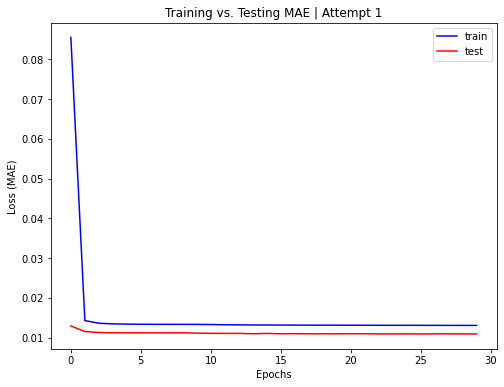

In [12]:
# plot history
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history.history['loss'], label='train', color="blue")
ax.plot(history.history['val_loss'], label='test', color="red")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss (MAE)")
ax.set_title("Training vs. Testing MAE | Attempt 1")
ax.legend()
plt.show()

Now, graph the predicted returns alongside the actual returns in `y_test`.

In [17]:
y_pred_3D = model.predict(X_test_3D)

3/3 [==============================] - 0s 2ms/step


There are multiple problems here. First off, the runtime is slow because of the extremely high batch size. Second, because of the high batch size, it's almost as if we're relying too much on snippets of historical data to the point where we're not really observing the whole picture, thus limiting our model and even making it to the point where even our training data isn't being predicted well. The sigmoid activation function does not necessarily seem to be a problem, but we can't really tell yet because of all the other problems. Hypothetically, I'd believe the sigmoid function would be the best because of its symmetric nature in that it'd be able to capture mean-reverting returns pretty well. 

Output the RMSE of the model, and provide some insight into the details with the model...

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3)                 156       
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________


Based on the model's summary, there are 160 total neurons in this RNN. 

### **Exploring Different Techniques for this RNN**

Let's try building a model without the LSTM layer to see how it impacts its performance.

In [20]:
# Design RNN
model = Sequential()
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="mae", optimizer="adam")

# Fit RNN
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=2)

Epoch 1/100
155/155 - 1s - loss: 0.4808 - val_loss: 0.4585 - 502ms/epoch - 3ms/step
Epoch 2/100
155/155 - 0s - loss: 0.4425 - val_loss: 0.4206 - 137ms/epoch - 885us/step
Epoch 3/100
155/155 - 0s - loss: 0.4052 - val_loss: 0.3841 - 133ms/epoch - 860us/step
Epoch 4/100
155/155 - 0s - loss: 0.3696 - val_loss: 0.3495 - 139ms/epoch - 894us/step
Epoch 5/100
155/155 - 0s - loss: 0.3360 - val_loss: 0.3171 - 213ms/epoch - 1ms/step
Epoch 6/100
155/155 - 0s - loss: 0.3049 - val_loss: 0.2873 - 129ms/epoch - 835us/step
Epoch 7/100
155/155 - 0s - loss: 0.2763 - val_loss: 0.2600 - 122ms/epoch - 786us/step
Epoch 8/100
155/155 - 0s - loss: 0.2502 - val_loss: 0.2352 - 132ms/epoch - 850us/step
Epoch 9/100
155/155 - 0s - loss: 0.2266 - val_loss: 0.2128 - 136ms/epoch - 874us/step
Epoch 10/100
155/155 - 0s - loss: 0.2053 - val_loss: 0.1929 - 126ms/epoch - 813us/step
Epoch 11/100
155/155 - 0s - loss: 0.1862 - val_loss: 0.1750 - 133ms/epoch - 857us/step
Epoch 12/100
155/155 - 0s - loss: 0.1691 - val_loss: 0.1

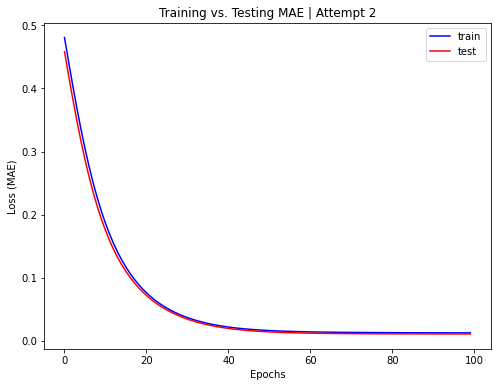

In [21]:
# plot history
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history.history['loss'], label='train', color="blue")
ax.plot(history.history['val_loss'], label='test', color="red")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss (MAE)")
ax.set_title("Training vs. Testing MAE | Attempt 2")
ax.legend()
plt.show()

This version of the RNN is actually much better despite the fact that it doesn't include the LSTM layer. Visually, the loss is converging to a value, but I am unsure if the value it's converging to is small or not. The training and testing cost are very similar for the most part as well, indicating that this model was actually pretty accurate in its predictions.


I do believe that the errors in my previous construction of the RNN with the LSTM layer had less to do with the existance of that layer and more to do with its poor construction. I want to plot predicted returns data alongside true returns data to get an idea of its performance graphically. We are dealing with percentage data here, so I really can't tell how to gage the 0.0126 loss function result.

In [22]:
y_pred = model.predict(X_test)

9/9 [==============================] - 0s 830us/step


Plot a graph comparing true returns in 2019 to predicted returns based on my RNN.

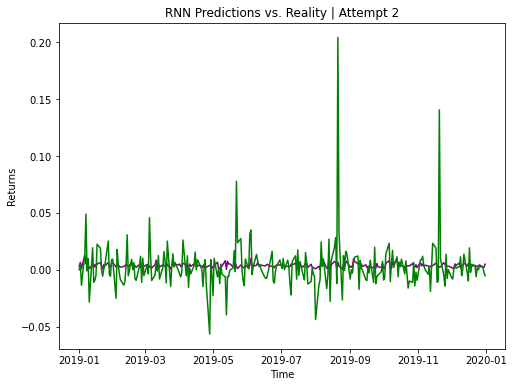

In [23]:
# plot history
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(y_test.index, y_pred, label='Predictions', color="purple")
ax.plot(y_test.index, y_test, label='Reality', color="green")
ax.set_xlabel("Time")
ax.set_ylabel("Returns")
ax.set_title("RNN Predictions vs. Reality | Attempt 2")
plt.show()

There is much less volatility in my models predictions in comparison to the actual model. Hence, I can conclude that my model, while much better than the previous one, is not great at predicting TGT stocks. The absense of an LSTM layer is likely hurting my model's performance, which is why I should bring it back and optimize it to the best of my ability.



This error also is partially not my fault, and the reason why is because TGT stocks are very volatile, especially depending on the time of year and current events. Still, I will try and see if I can make a slightly more reactionary model that can minimize the residuals that appear in my model.

Showing a model summary and calculating RMSE...

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


The model contains a total of 10 neurons.

In [25]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.020


The RMSE is 0.02, which is larger than the model with the LSML layer.

#### **Adjusting my Activation Function**

I am going to test the ReLU and tanh activation functions as well on this RNN to see the differences that it makes, if any. I predict that the ReLU activation function will create worse predictions, and the tanh function will likely have similar results to the sigmoid function. I'm also increasing the number of neurons in the Dense hidden layer of the RNN.

In [26]:
# Design RNN
model = Sequential()
model.add(Dense(1, activation="relu"))
model.compile(loss="mae", optimizer="adam")

# Fit RNN
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=2)

Epoch 1/100
155/155 - 0s - loss: 0.0166 - val_loss: 0.0124 - 461ms/epoch - 3ms/step
Epoch 2/100
155/155 - 0s - loss: 0.0139 - val_loss: 0.0116 - 121ms/epoch - 781us/step
Epoch 3/100
155/155 - 0s - loss: 0.0136 - val_loss: 0.0114 - 128ms/epoch - 827us/step
Epoch 4/100
155/155 - 0s - loss: 0.0135 - val_loss: 0.0113 - 156ms/epoch - 1ms/step
Epoch 5/100
155/155 - 0s - loss: 0.0134 - val_loss: 0.0112 - 130ms/epoch - 840us/step
Epoch 6/100
155/155 - 0s - loss: 0.0134 - val_loss: 0.0112 - 132ms/epoch - 849us/step
Epoch 7/100
155/155 - 0s - loss: 0.0133 - val_loss: 0.0112 - 128ms/epoch - 824us/step
Epoch 8/100
155/155 - 0s - loss: 0.0133 - val_loss: 0.0112 - 154ms/epoch - 993us/step
Epoch 9/100
155/155 - 0s - loss: 0.0133 - val_loss: 0.0112 - 129ms/epoch - 831us/step
Epoch 10/100
155/155 - 0s - loss: 0.0133 - val_loss: 0.0112 - 128ms/epoch - 826us/step
Epoch 11/100
155/155 - 0s - loss: 0.0132 - val_loss: 0.0112 - 132ms/epoch - 849us/step
Epoch 12/100
155/155 - 0s - loss: 0.0132 - val_loss: 0.0

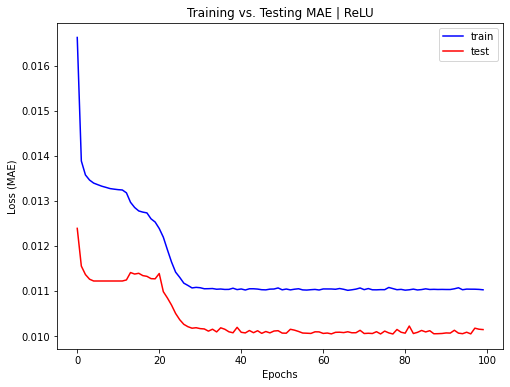

In [27]:
# plot history
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history.history['loss'], label='train', color="blue")
ax.plot(history.history['val_loss'], label='test', color="red")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss (MAE)")
ax.set_title("Training vs. Testing MAE | ReLU")
ax.legend()
plt.show()

9/9 [==============================] - 0s 1ms/step


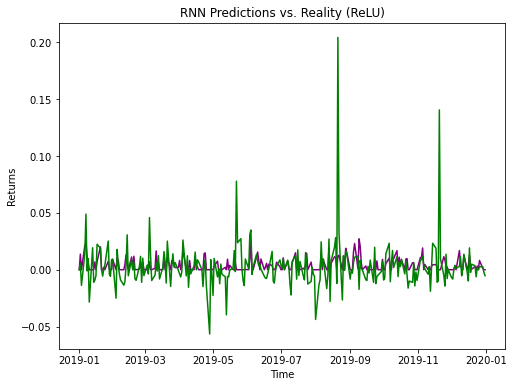

In [28]:
# Make Predictions
y_pred = model.predict(X_test)

# plot history
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(y_test.index, y_pred, label='Predictions', color="purple")
ax.plot(y_test.index, y_test, label='Reality', color="green")
ax.set_xlabel("Time")
ax.set_ylabel("Returns")
ax.set_title("RNN Predictions vs. Reality (ReLU)")
plt.show()

The ReLU function is not that great, and the same phenomenon occurs when Testing MSE is close to Training MSE.

Now observing the model summary and calculating RMSE...

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


There are 10 total neurons in this RNN.

In [30]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.019


RMSE is 0.019, but values below 0 are entirely omitted from calculation.

Now observing tanh...

In [31]:
# Design RNN
model = Sequential()
model.add(Dense(1, activation="tanh"))
model.compile(loss="mae", optimizer="adam")

# Fit RNN
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=2)

Epoch 1/100
155/155 - 0s - loss: 0.0245 - val_loss: 0.0201 - 477ms/epoch - 3ms/step
Epoch 2/100
155/155 - 0s - loss: 0.0158 - val_loss: 0.0132 - 126ms/epoch - 814us/step
Epoch 3/100
155/155 - 0s - loss: 0.0124 - val_loss: 0.0108 - 162ms/epoch - 1ms/step
Epoch 4/100
155/155 - 0s - loss: 0.0113 - val_loss: 0.0100 - 173ms/epoch - 1ms/step
Epoch 5/100
155/155 - 0s - loss: 0.0106 - val_loss: 0.0095 - 158ms/epoch - 1ms/step
Epoch 6/100
155/155 - 0s - loss: 0.0102 - val_loss: 0.0093 - 129ms/epoch - 835us/step
Epoch 7/100
155/155 - 0s - loss: 0.0097 - val_loss: 0.0091 - 128ms/epoch - 828us/step
Epoch 8/100
155/155 - 0s - loss: 0.0095 - val_loss: 0.0090 - 135ms/epoch - 869us/step
Epoch 9/100
155/155 - 0s - loss: 0.0093 - val_loss: 0.0089 - 151ms/epoch - 974us/step
Epoch 10/100
155/155 - 0s - loss: 0.0091 - val_loss: 0.0089 - 144ms/epoch - 929us/step
Epoch 11/100
155/155 - 0s - loss: 0.0090 - val_loss: 0.0089 - 142ms/epoch - 914us/step
Epoch 12/100
155/155 - 0s - loss: 0.0090 - val_loss: 0.0090 

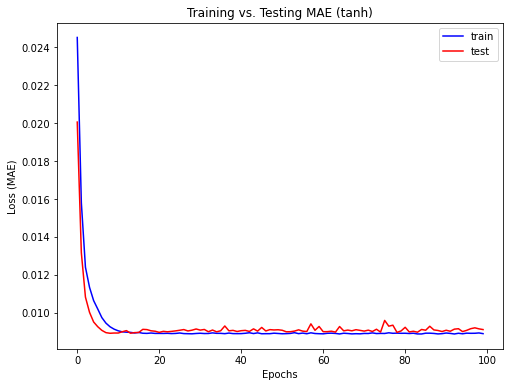

In [32]:
# plot history
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history.history['loss'], label='train', color="blue")
ax.plot(history.history['val_loss'], label='test', color="red")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss (MAE)")
ax.set_title("Training vs. Testing MAE (tanh)")
ax.legend()
plt.show()

9/9 [==============================] - 0s 1ms/step


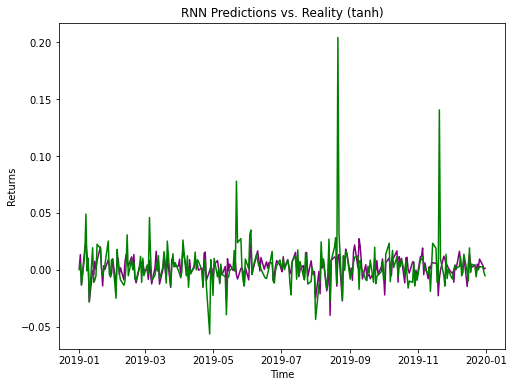

In [33]:
# Make Predictions
y_pred = model.predict(X_test)

# plot history
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(y_test.index, y_pred, label='Predictions', color="purple")
ax.plot(y_test.index, y_test, label='Reality', color="green")
ax.set_xlabel("Time")
ax.set_ylabel("Returns")
ax.set_title("RNN Predictions vs. Reality (tanh)")
plt.show()

Evaluating our model, and finding the RMSE,

In [34]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


There are a total of 10 neurons in this model.

In [35]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.019


The hyperbolic tangent activation function actually yielded the smallest loss out of all the other ones that we were just examining in comparison to the others tested so far, so I will stick with tanh as my activation function as I continue adjusting the LSTM to find values that may work well with model. 


The tanh function was able to capture much more of the volatility that existed with the stock than the sigmoid function, as seen in this graph. The ReLU function struggled, because it was not able to predict negative returns.

### **Applying Both Hyperbolic Tangent and the LSTM Layer**

I believe that this combination will perform well in predicting the percentage returns for TGT. This hidden layer worked well independently before, and the function with hyperbolic tangent with only 1 hidden layer worked great as well.

In [36]:
# Design RNN
model = Sequential()
model.add(LSTM(3, input_shape=(X_train_3D.shape[1], X_train_3D.shape[2])))
model.add(Dense(1, activation="tanh"))
model.compile(loss="mae", optimizer="adam")

# Fit RNN
history = model.fit(X_train_3D, y_train_2D, epochs=10, batch_size=1, validation_data=(X_test_3D, y_test_2D), verbose=2)

Epoch 1/10
1652/1652 - 4s - loss: 0.0128 - val_loss: 0.0108 - 4s/epoch - 3ms/step
Epoch 2/10
1652/1652 - 3s - loss: 0.0127 - val_loss: 0.0113 - 3s/epoch - 2ms/step
Epoch 3/10
1652/1652 - 2s - loss: 0.0127 - val_loss: 0.0109 - 2s/epoch - 1ms/step
Epoch 4/10
1652/1652 - 2s - loss: 0.0126 - val_loss: 0.0107 - 2s/epoch - 1ms/step
Epoch 5/10
1652/1652 - 2s - loss: 0.0126 - val_loss: 0.0108 - 2s/epoch - 1ms/step
Epoch 6/10
1652/1652 - 2s - loss: 0.0126 - val_loss: 0.0113 - 2s/epoch - 1ms/step
Epoch 7/10
1652/1652 - 2s - loss: 0.0126 - val_loss: 0.0108 - 2s/epoch - 1ms/step
Epoch 8/10
1652/1652 - 2s - loss: 0.0127 - val_loss: 0.0113 - 2s/epoch - 1ms/step
Epoch 9/10
1652/1652 - 3s - loss: 0.0126 - val_loss: 0.0107 - 3s/epoch - 2ms/step
Epoch 10/10
1652/1652 - 2s - loss: 0.0126 - val_loss: 0.0109 - 2s/epoch - 1ms/step


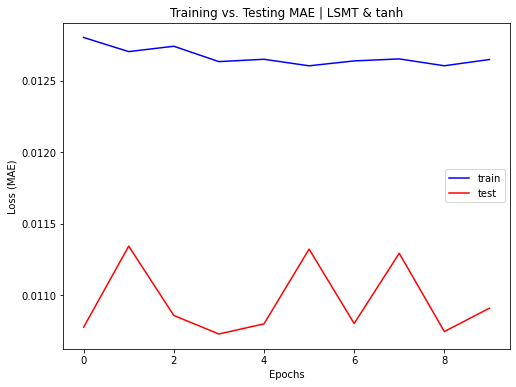

In [37]:
# plot history
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history.history['loss'], label='train', color="blue")
ax.plot(history.history['val_loss'], label='test', color="red")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss (MAE)")
ax.set_title("Training vs. Testing MAE | LSMT & tanh")
ax.legend()
plt.show()

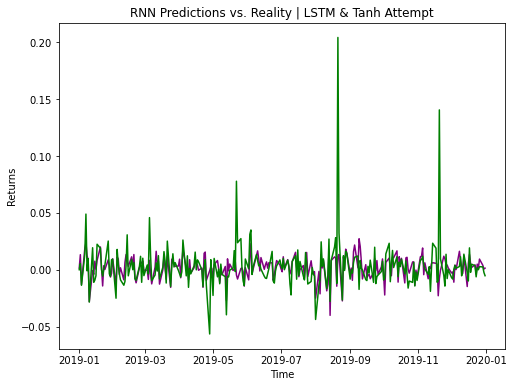

In [38]:
# plot history
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(y_test.index, y_pred, label='Predictions', color="purple")
ax.plot(y_test.index, y_test, label='Reality', color="green")
ax.set_xlabel("Time")
ax.set_ylabel("Returns")
ax.set_title("RNN Predictions vs. Reality | LSTM & Tanh Attempt")
plt.show()

Evaluating our model and finding the RMSE...

In [39]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 3)                 156       
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________


There are 160 neurons in the RNN.

In [40]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.019


The RMSE is actually reminiscent of some of the other models and does not necessarily out-perform any of them. This model did not perform as well as I expected, and I actually prefer the model without the LSML layer, because it predicted a wider range of values and didn't necessarily restrict the domain of prediction.

## **Conclusion**

Based off of all my analyses, I can conclude that the single layer recurrent neural network with only 1 Dense hidden layer and a $\tanh$ activation function worked the best out of all my models. 



The first model I came up with—which was basically a double hidden layer RNN with one LSTM layer and one Dense layer—worked decently, but it easily had its shortcomings in that it didn't do a great job at capturing any of the volatility that occurred in the true returns in 2019. 


The next model, which maintained the same characteristics with the sigmoid activation function but did not have the Dense layer, performed even better, maintaining a smaller RMSE and smaller loss function. The training and testing MAE graph also showed identical trends between the models prediction accuracy of the two sets.


When I switched the activation function to ReLU, several errors popped up, because we were predicting stock percentage returns which tend to be both positive *and* negative. Negative values cannot be returned with ReLU, so several of our results could not have been predicted in the first place.


Once I finally switched to using hyperbolic tangent as my activation function, however, the trend in our graph finally began to comparatively match the volatility of TGT more than any of our other predictions. The training v. testing MAE graph shows the training loss sinking down as epochs grow with testing following that trend pretty clearly with minor deviations.


One thing to note as well was that my predictors that I chose did a great job at actually predicting the TGT returns or at least got decently close to creating a model that somewhat recognized the intricate patterns of the equity and mapped itself accordingly. The predictors I chose covered several bases for the prediction: understanding the hollistic performance of the U.S. stock market, breaking down how the retail sector of the stock market is performing, and understanding competitor performance. 